<a href="https://colab.research.google.com/github/jj364/deep_learning/blob/main/Keras_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU
from keras.optimizers import Adam
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
import numpy as np
import random

In [36]:
(train_x, train_y), (test_x, test_y) = load_data()  # Load dataset

Get some basic info about dataset

In [37]:
print(f"Train size: {train_x.shape}")
print(f"Test size: {test_x.shape}")
print(f"Number of training samples: {train_x.shape[0]}")
print(f"Number of testing samples: {test_x.shape[0]}")
print(f"Sample dimensions: {train_x.shape[1]} x {train_x.shape[2]} px")

Train size: (60000, 28, 28)
Test size: (10000, 28, 28)
Number of training samples: 60000
Number of testing samples: 10000
Sample dimensions: 28 x 28 px


Plot some samples - title is 'ground truth' label

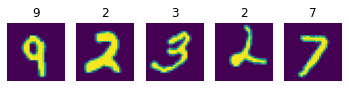

In [38]:
sample_indicies = [random.randint(0, train_x.shape[0]-1) for _ in range(5)]
fig, ax = plt.subplots(1, 5, figsize=(6,2))
for i,a in enumerate(ax):
  a.imshow(train_x[sample_indicies[i]])
  a.axis('off')
  a.set_title(train_y[sample_indicies[i]])  # provide true label
plt.show()

# Time to work on the Generative Adversarial Network (GAN)
Firstly, let's define the descriminator which tries to work out which data is 'real' and which has been generated

In [39]:
def create_discriminator(dims=(28,28,1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), input_shape=dims))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), input_shape=dims))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  opt = Adam(lr = 0.0005, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [53]:
def get_real_samples(dset, n):  # get n samples from dataset
  ix = np.random.randint(0, dset.shape[0], n)
  X = dset[ix]
  Y = np.ones((n, 1))  # One label for 'real' samples
  return X, Y

In [59]:
def get_fake_samples(n):
  X = np.random.rand(28 * 28 * n)
  X = np.reshape(X, (n, 28, 28, 1))
  Y = np.zeros((n, 1))  # Zero label for 'fake' sample
  return X, Y

We need to prepare the data for training

In [43]:
X = np.expand_dims(train_x, axis=-1)  # Even though its b&w image need 3rd channel
X = X.astype('float32')  # Needs to be float for rescaling
X = X / 255.0  # Rescale between 0 and 1

Now we can train the discriminator

In [ ]:
n_batches = 100
batch_size = 256
model = create_discriminator()

for b in range(n_batches):
  X_real, y_real = get_real_samples(X, int(batch_size/2))
  _, real_acc = model.train_on_batch(X_real, y_real)
  X_fake, y_fake = get_fake_samples(int(batch_size/2))
  _, fake_acc = model.train_on_batch(X_fake, y_fake)
  print(f'Accuracy: Real = {real_acc:.2f}  Fake = {fake_acc:.2f}')

In [52]:
type(X.shape[0])

int